In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re

#### a. Data preparation

In [2]:
data = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

In [ ]:
# for importing data from txt file
# with open("data.txt", "r", encoding="utf-8") as file:
#     data = file.read()

In [3]:
sentences = data.split(".")

In [4]:
sentences

['We are about to study the idea of a computational process',
 '\nComputational processes are abstract beings that inhabit computers',
 '\nAs they evolve, processes manipulate other abstract things called data',
 '\nThe evolution of a process is directed by a pattern of rules\ncalled a program',
 ' People create programs to direct processes',
 ' In effect,\nwe conjure the spirits of the computer with our spells',
 '']

In [5]:
#Clean Data
clean_sentences = []
for sentence in sentences:
    # skip empty string
    if sentence == "":
        continue;
    # remove special characters
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)
    # remove 1 letter words
    sentence = re.sub(r'(?:^| )\w(?:$| )', ' ', sentence).strip()
    # lower all characters
    sentence = sentence.lower()
    clean_sentences.append(sentence)

In [6]:
clean_sentences

['we are about to study the idea of computational process',
 'computational processes are abstract beings that inhabit computers',
 'as they evolve processes manipulate other abstract things called data',
 'the evolution of process is directed by pattern of rules called program',
 'people create programs to direct processes',
 'in effect we conjure the spirits of the computer with our spells']

In [7]:
# Define the corpus
corpus = clean_sentences

In [8]:
# Convert the corpus to a sequence of integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
print("After converting our words in the corpus \
into vector of integers:")
print(sequences)

After converting our words in the corpus into vector of integers:
[[4, 5, 11, 6, 12, 1, 13, 2, 7, 8], [7, 3, 5, 9, 14, 15, 16, 17], [18, 19, 20, 3, 21, 22, 9, 23, 10, 24], [1, 25, 2, 8, 26, 27, 28, 29, 2, 30, 10, 31], [32, 33, 34, 6, 35, 3], [36, 37, 4, 38, 1, 39, 2, 1, 40, 41, 42, 43]]


In [9]:
# creating dictionary for word to index and index to word
index_to_word_map = {}
word_to_index_map = {}
for index_1, sequence in enumerate(sequences):
    print(sequence)
    words_in_sentence = clean_sentences[index_1].split()
    print(words_in_sentence)
    for index_2, value in enumerate(sequence):
        index_to_word_map[value] = words_in_sentence[index_2]
        word_to_index_map[words_in_sentence[index_2]] = value

[4, 5, 11, 6, 12, 1, 13, 2, 7, 8]
['we', 'are', 'about', 'to', 'study', 'the', 'idea', 'of', 'computational', 'process']
[7, 3, 5, 9, 14, 15, 16, 17]
['computational', 'processes', 'are', 'abstract', 'beings', 'that', 'inhabit', 'computers']
[18, 19, 20, 3, 21, 22, 9, 23, 10, 24]
['as', 'they', 'evolve', 'processes', 'manipulate', 'other', 'abstract', 'things', 'called', 'data']
[1, 25, 2, 8, 26, 27, 28, 29, 2, 30, 10, 31]
['the', 'evolution', 'of', 'process', 'is', 'directed', 'by', 'pattern', 'of', 'rules', 'called', 'program']
[32, 33, 34, 6, 35, 3]
['people', 'create', 'programs', 'to', 'direct', 'processes']
[36, 37, 4, 38, 1, 39, 2, 1, 40, 41, 42, 43]
['in', 'effect', 'we', 'conjure', 'the', 'spirits', 'of', 'the', 'computer', 'with', 'our', 'spells']


In [10]:
print(index_to_word_map)
print("\n")
print(word_to_index_map)

{4: 'we', 5: 'are', 11: 'about', 6: 'to', 12: 'study', 1: 'the', 13: 'idea', 2: 'of', 7: 'computational', 8: 'process', 3: 'processes', 9: 'abstract', 14: 'beings', 15: 'that', 16: 'inhabit', 17: 'computers', 18: 'as', 19: 'they', 20: 'evolve', 21: 'manipulate', 22: 'other', 23: 'things', 10: 'called', 24: 'data', 25: 'evolution', 26: 'is', 27: 'directed', 28: 'by', 29: 'pattern', 30: 'rules', 31: 'program', 32: 'people', 33: 'create', 34: 'programs', 35: 'direct', 36: 'in', 37: 'effect', 38: 'conjure', 39: 'spirits', 40: 'computer', 41: 'with', 42: 'our', 43: 'spells'}


{'we': 4, 'are': 5, 'about': 11, 'to': 6, 'study': 12, 'the': 1, 'idea': 13, 'of': 2, 'computational': 7, 'process': 8, 'processes': 3, 'abstract': 9, 'beings': 14, 'that': 15, 'inhabit': 16, 'computers': 17, 'as': 18, 'they': 19, 'evolve': 20, 'manipulate': 21, 'other': 22, 'things': 23, 'called': 10, 'data': 24, 'evolution': 25, 'is': 26, 'directed': 27, 'by': 28, 'pattern': 29, 'rules': 30, 'program': 31, 'people':

#### b. Generate training data

In [11]:
# Define the parameters
vocab_size = len(tokenizer.word_index) + 1
embedding_size = 10
window_size = 2

# Generate the context-target pairs
contexts = []
targets = []
for sequence in sequences:
	for i in range(window_size, len(sequence) - window_size):
		context = sequence[i - window_size:i] + sequence[i + 1:i + window_size + 1]
		target = sequence[i]
		contexts.append(context)
		targets.append(target)

In [12]:
# sample of training data
for i in range(5):
    words = []
    target = index_to_word_map.get(targets[i])
    for j in contexts[i]:
        words.append(index_to_word_map.get(j))
    print(words, "=>", target)

['we', 'are', 'to', 'study'] => about
['are', 'about', 'study', 'the'] => to
['about', 'to', 'the', 'idea'] => study
['to', 'study', 'idea', 'of'] => the
['study', 'the', 'of', 'computational'] => idea


In [13]:
# Convert the contexts and targets to numpy arrays
X = np.array(contexts)
Y = np.array(targets)

#### c. Train model

In [14]:
# Define the CBOW model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=2 * window_size))
model.add(Lambda(lambda x: tf.reduce_mean(x, axis=1)))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(units=vocab_size, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X, Y, epochs=200, verbose=1)

Epoch 1/200
2/2 [==============================] - 1s 28ms/step - loss: 3.7837 - accuracy: 0.0294
Epoch 2/200
2/2 [==============================] - 0s 18ms/step - loss: 3.7755 - accuracy: 0.2059
Epoch 3/200
2/2 [==============================] - 0s 15ms/step - loss: 3.7694 - accuracy: 0.1471
Epoch 4/200
2/2 [==============================] - 0s 17ms/step - loss: 3.7626 - accuracy: 0.1471
Epoch 5/200
2/2 [==============================] - 0s 12ms/step - loss: 3.7543 - accuracy: 0.1471
Epoch 6/200
2/2 [==============================] - 0s 18ms/step - loss: 3.7456 - accuracy: 0.1471
Epoch 7/200
2/2 [==============================] - 0s 17ms/step - loss: 3.7348 - accuracy: 0.1471
Epoch 8/200
2/2 [==============================] - 0s 16ms/step - loss: 3.7216 - accuracy: 0.1765
Epoch 9/200
2/2 [==============================] - 0s 12ms/step - loss: 3.7066 - accuracy: 0.1765
Epoch 10/200
2/2 [==============================] - 0s 19ms/step - loss: 3.6882 - accuracy: 0.2059
Epoch 11/200
2/2 [=

In [15]:
# Get the word embeddings
embeddings = model.get_weights()[0]

# Perform PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

#### d. Output

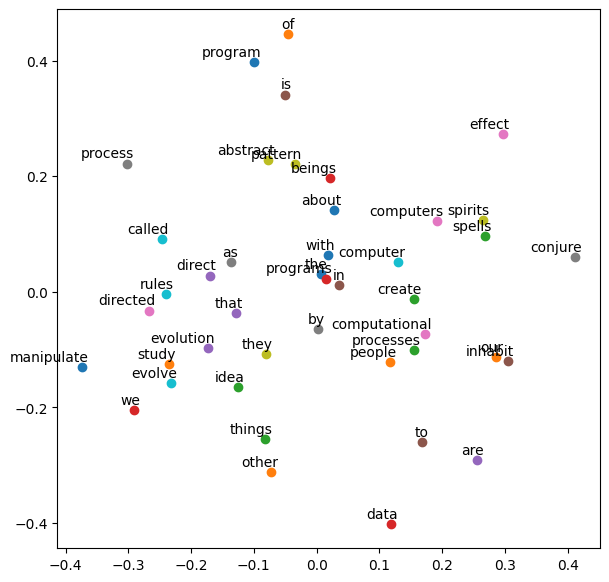

In [16]:
# Visualize the embeddings
plt.figure(figsize=(7, 7))
for i, word in enumerate(tokenizer.word_index.keys()):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points',
                 ha='right', va='bottom')
plt.show()

In [17]:
# test model
test_sentenses = [
    "we are to study",
    "create programs direct processes",
    "spirits process study program",
    "idea study people create"
]

In [18]:
for test_sentense in test_sentenses:
    test_words = test_sentense.split(" ")
    print("Words: ", test_words)
    x_test = []
    for i in test_words:
        x_test.append(word_to_index_map.get(i))
    x_test = np.array([x_test])
    print("Indexs: ", x_test)
    test_predictions = model.predict(x_test)
    y_pred = np.argmax(test_predictions[0])
    print("Predictons: ",test_words, " => ", index_to_word_map.get(y_pred))
    print("\n")

Words:  ['we', 'are', 'to', 'study']
Indexs:  [[ 4  5  6 12]]
1/1 [==============================] - 0s 108ms/step
Predictons:  ['we', 'are', 'to', 'study']  =>  about


Words:  ['create', 'programs', 'direct', 'processes']
Indexs:  [[33 34 35  3]]
1/1 [==============================] - 0s 25ms/step
Predictons:  ['create', 'programs', 'direct', 'processes']  =>  to


Words:  ['spirits', 'process', 'study', 'program']
Indexs:  [[39  8 12 31]]
1/1 [==============================] - 0s 20ms/step
Predictons:  ['spirits', 'process', 'study', 'program']  =>  the


Words:  ['idea', 'study', 'people', 'create']
Indexs:  [[13 12 32 33]]
1/1 [==============================] - 0s 24ms/step
Predictons:  ['idea', 'study', 'people', 'create']  =>  programs


